In [1]:
!.[alt text].(./figs/mycnn.jpg)

/bin/sh: -c: line 0: syntax error near unexpected token `('
/bin/sh: -c: line 0: `.[alt text].(./figs/mycnn.jpg)'


# Load packages

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST train, test dataset 가져오기

In [3]:
# "": 현재 폴더에 MNIST 있음
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(),  #train 용으로 쓰겠다.
                      target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(),  #test 용으로 쓰겠다.
                      target_transform=None, download=True)

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label: 5


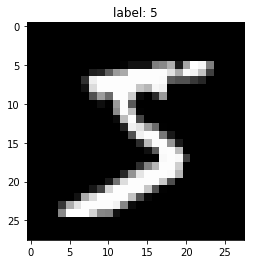

In [4]:
print "mnist_train 길이:", len(mnist_train)
print "mnist_test 길이:", len(mnist_test)

# 데이터 하나 형태
image, label=mnist_train.__getitem__(0)  # 0번째 데이터
print "image data 형태:", image.size()
print "label:", label

# 그리기
img=image.numpy()  # image 타입을 numpy로 변환 (1,28,28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

# MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


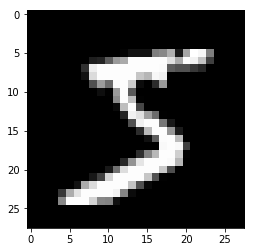

0


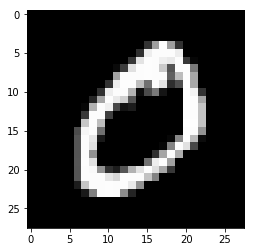

4


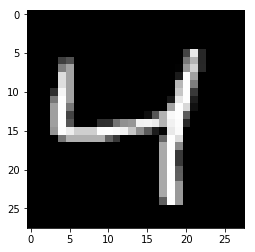

In [5]:
print(mnist_train[0][1])  # label
print(mnist_train[0][0].size())  # image

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0],cmap='gray')
    plt.show()

# convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


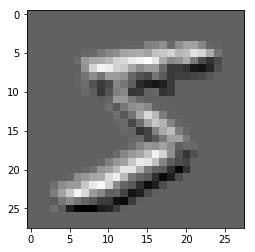

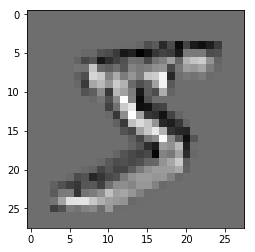

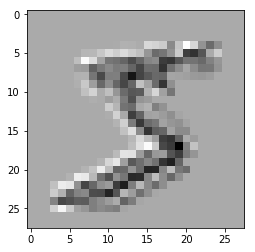

In [6]:
# mnist 의 첫 번째 이미니, 라벨 가져오기
image, label = mnist_train[0]
# view: tensor 의 사이즈 조절. -1: 해당 차원 차원 확장시켜라
# [1, 28, 28] -> [1, 1, 28, 28]
image=image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print label

# convolutional filter 정의
conv_layer=nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,padding=1)
# image 에 filter 적용
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show()

# CNN 만들기

### train, test data 가져오기

In [7]:
import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate = 0.0002
num_epoch = 10  # 1000

In [8]:
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size,  # mnist_train 를 트레인 시키고
                                           shuffle=True, num_workers=2, 
                                           drop_last=True)  # batch_size 만큼 나눌 때 나머지는 버려라
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size, 
                                          shuffle=False, num_workers=2, 
                                          drop_last=True)

# CNN 클래스 만들기 (모델 만들기)

In [9]:
class CNN(nn.Module):  # nn.Module 상속받음
    def __init__(self):
        super(CNN,self).__init__()  # 28 x 28
        self.layer=nn.Sequential(
            nn.Conv2d(1,16,5,padding=2),
            nn.ReLU(),
           
            nn.Conv2d(16,32,5,padding=2),  # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # 28 x 28 -> 14 x 14
            
            nn.Conv2d(32,64,5,padding=2),  # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)  # 14 x 14 -> 7 x 7
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        return out
    
model=CNN()#.cuda()

In [10]:
# 파라미터 체크하기
for parameter in model.parameters():
    #print(parameter)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [11]:
# loss function, optimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# optimization

In [12]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):  # batch_size 만큼
        x = Variable(image)  #.cuda()
        y_ = Variable(label)  #.cuda()
        
        optimizer.zero_grad()  # optimizer 안에서 이전 gradient 들을 초기화.
        output=model.forward(x)
        loss=loss_func(output, y_)
        loss.backward()  # gradient 계산
        optimizer.step()  # parameter 업데이트
        
        if j%50==0:
            print(loss, j, i)

(tensor(2.3222, grad_fn=<NllLossBackward>), 0, 0)
(tensor(1.7981, grad_fn=<NllLossBackward>), 50, 0)
(tensor(0.7257, grad_fn=<NllLossBackward>), 0, 1)
(tensor(0.3568, grad_fn=<NllLossBackward>), 50, 1)
(tensor(0.2028, grad_fn=<NllLossBackward>), 0, 2)
(tensor(0.3678, grad_fn=<NllLossBackward>), 50, 2)
(tensor(0.3611, grad_fn=<NllLossBackward>), 0, 3)
(tensor(0.0507, grad_fn=<NllLossBackward>), 50, 3)
(tensor(0.1019, grad_fn=<NllLossBackward>), 0, 4)
(tensor(0.0649, grad_fn=<NllLossBackward>), 50, 4)
(tensor(0.2473, grad_fn=<NllLossBackward>), 0, 5)
(tensor(0.0938, grad_fn=<NllLossBackward>), 50, 5)
(tensor(0.3947, grad_fn=<NllLossBackward>), 0, 6)
(tensor(0.3956, grad_fn=<NllLossBackward>), 50, 6)
(tensor(0.0125, grad_fn=<NllLossBackward>), 0, 7)
(tensor(0.0511, grad_fn=<NllLossBackward>), 50, 7)
(tensor(0.3679, grad_fn=<NllLossBackward>), 0, 8)
(tensor(0.0321, grad_fn=<NllLossBackward>), 50, 8)
(tensor(0.0899, grad_fn=<NllLossBackward>), 0, 9)
(tensor(0.0030, grad_fn=<NllLossBackward>

In [13]:
# 모델 저장시키기
torch.save(model, 'nets/mycnn_model_%d.pkl'%(num_epoch))

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
try:
    # 미리 학습시킨 네트워크의 파라미터 집합 [피클]이라 발음함.
    model=torch.load('nets/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not restored")

model restored


In [15]:
def ComputeAccr(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs, labels] in enumerate(dloader):  # batch_size 만큼
        img=Variable(imgs)#.cuda()  # x
        label = Variable(labels)  # y
        #label = Variable(labels).cuda()
        # .cuda() : GPU 에 로드되기 위함. 만약 CPU로 설정되어 있다면 에러남
        
        
        output=imodel.forward(img)  # forward prop.
        _, output_index=torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [16]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 94.9700012207
